# 0. Setup

In [7]:
# %pip install --upgrade langchain langsmith langgraph langchain_openai openai python-dotenv javascript numpy genson
%reload_ext autoreload
%autoreload 2

In [8]:
# Setup
from dotenv import load_dotenv
import sys
sys.path.append('..')
import os
from langchain_core.messages import HumanMessage
from graph.master_graph import GraphState
from graph.trivial_agent_graph import IndexerAgentGraphBuilder
from agents.IndexerAgent import indexer_agent_model, tool_executor
from tools.JavaScriptRunner import tool_js_on_block_schema_func, tool_js_on_block_schema
from agents.BlockExtractorAgent import run_js_on_block_only_schema,JsResponse
import json
from IPython.display import Image, display

# Load .env file
load_dotenv('.env')

# Set model variables
OPENAI_BASE_URL = "https://api.openai.com/v1"
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_ORGANIZATION = os.getenv("OPENAI_ORGANIZATION")


os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")

# Master Run

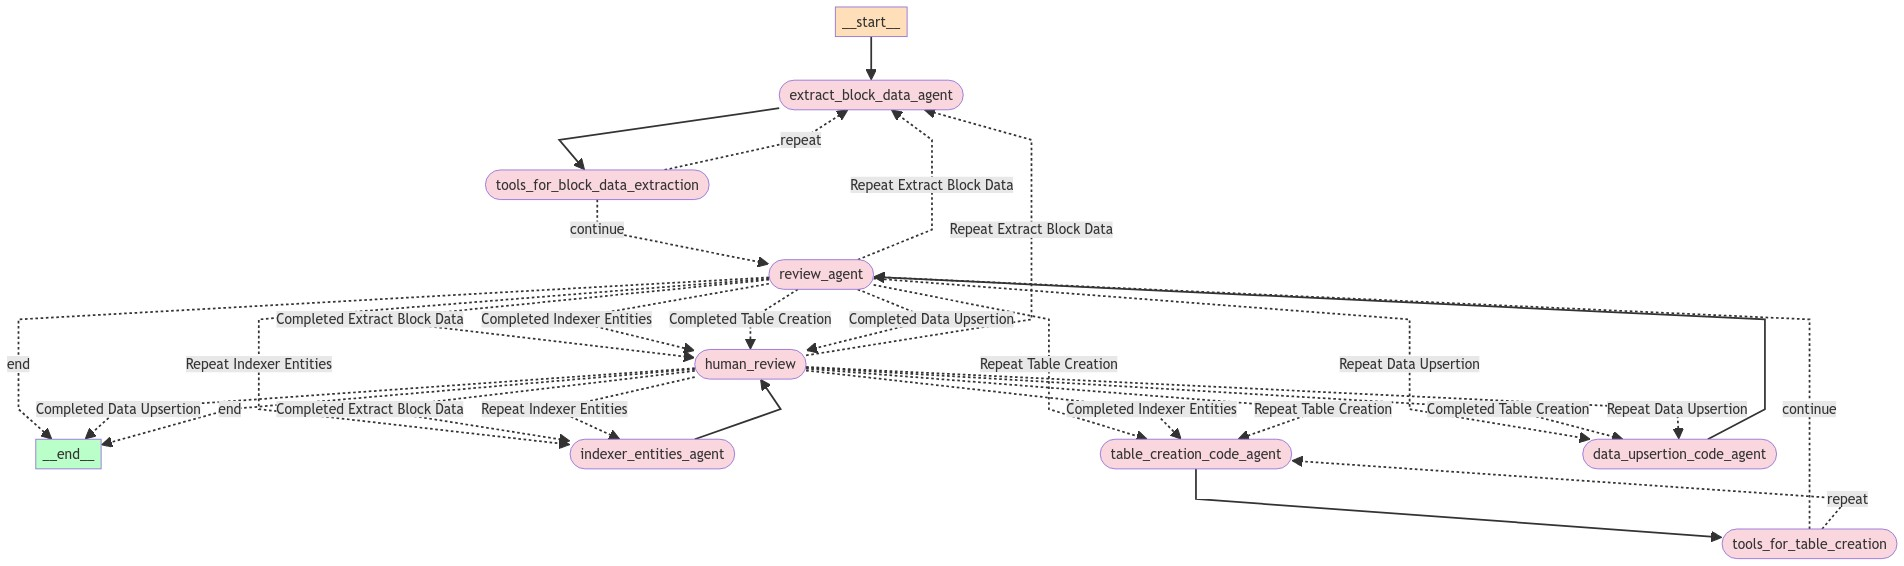

In [9]:
from graph.master_graph import create_graph
from langchain_core.messages import HumanMessage

question = """
    Extract all FunctionCalls where receiverId is 'app.nearcrowd.near'. For each function call, I need signerId, block height, receiptId, block datetime, methodName. 
    Also add all fields from args that are decoded from base64-encoded JSON. I only need actions for successful receipts. 
    Use block height 119688212 for parsing the JS code, and only pull data from the last 2 days.
    """

inputs = {
    "original_prompt":question,
    "block_limit":10,
    "previous_day_limit":3,
    "messages":[],
    "block_heights":[],
    "block_data_extraction_code":"",
    "entity_schema": "",
    "table_creation_code":"",
    "data_upsertion_code": "",
    "iterations": 0,
    "indexer_entities_description":"",
    "error":"",
    "should_continue": False,
    }

workflow = create_graph()
app = workflow.compile()
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [10]:
# RUN MASTER APP
# result = app.invoke(inputs)

# table_creation_code = result['table_creation_code'].replace("\\n","\n")
# block_data_extraction_code = result['block_data_extraction_code'].replace("\\n","\n")
# data_upsertion_code = result['data_upsertion_code'].replace("\\n","\n")
# indexer_entities_description = result['indexer_entities_description'].replace("\\n","\n")
# print(f'SQL DDL: {table_creation_code}')
# print(f'Data Upsertion Logic: {data_upsertion_code}')

# 1. Block Extractor Agent

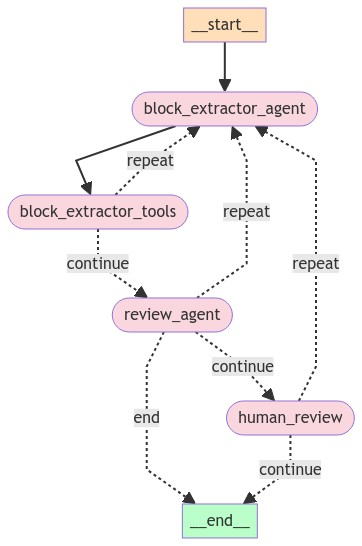

In [11]:
# Load agents
from tools.NearLake import tool_get_block_heights
from tools.JavaScriptRunner import tool_js_on_block_schema_func,tool_infer_schema_of_js
from tools.database import tool_run_sql_ddl
from agents.BlockExtractorAgent import BlockExtractorAgent,block_extractor_agent_model
from agents.TableCreationAgent import TableCreationAgent,table_creation_code_model_v2,TableCreationResponse
from agents.ReviewAgent import review_agent_model,ReviewAgent
from agents.DataUpsertionAgent import DataUpsertionCodeAgent,data_upsertion_code_model
from langgraph.prebuilt import ToolExecutor

# Block Extractor Agent
block_extractor_tools = [tool_js_on_block_schema_func, tool_infer_schema_of_js,tool_get_block_heights]
block_extractor_model = block_extractor_agent_model(block_extractor_tools) # v2 adds the jsresponse parser to prompt
block_extractor_agent = BlockExtractorAgent(block_extractor_model,ToolExecutor(block_extractor_tools))

# DDL Agent
table_creation_tools = [tool_run_sql_ddl]
table_creation_code_agent_model = table_creation_code_model_v2(table_creation_tools)
table_creation_code_agent = TableCreationAgent(table_creation_code_agent_model,ToolExecutor(table_creation_tools))

# DataUpsertion Agent
data_upsertion_code_agent_model = data_upsertion_code_model()
data_upsertion_code_agent = DataUpsertionCodeAgent(data_upsertion_code_agent_model)

# Review Agent
review_agent_model = review_agent_model()
review_agent = ReviewAgent(review_agent_model)

# Define conditional logic  
def code_review_router(state):
    should_continue=state.should_continue
    iterations = state.iterations
    if should_continue:
        return "continue"
    elif iterations > 3:
        return "end"
    else:
        return "repeat"
    
def should_review(state):
    entity_schema = state.entity_schema
    error = state.error
    # If block schema is no longer null we review schema
    if entity_schema != "" or error != "":
        return "continue"
    else:
        return "repeat"
    
def human_review_router(state):
    should_continue = state.should_continue
    if should_continue==True:
        return "continue"
    else:
        return "repeat"
        

from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

## Define the Agent nodes
workflow.add_node("block_extractor_agent", block_extractor_agent.call_model)
workflow.add_node("review_agent", review_agent.call_model)

## Tool Nodes
workflow.add_node("block_extractor_tools",block_extractor_agent.call_tool)

## Human Review
workflow.add_node("human_review",review_agent.human_review)

## Add Edges
workflow.set_entry_point("block_extractor_agent")
workflow.add_edge("block_extractor_agent", "block_extractor_tools")

# Add Conditional Edges
# Check if schema is filled in
workflow.add_conditional_edges(
    "block_extractor_tools",
    should_review,
    {
        "repeat":"block_extractor_agent",
        "continue": "review_agent",
    }   
)
workflow.add_conditional_edges(
    "review_agent",
    code_review_router,
    {
        "continue":"human_review",
        "repeat": "block_extractor_agent",
        "end":END,
    }   
)
# Human review of schema
workflow.add_conditional_edges(
    "human_review",
    human_review_router,
    {
        "continue": END,
        "repeat": "block_extractor_agent",
    }   
)

be_app = workflow.compile()
display(Image(be_app.get_graph(xray=True).draw_mermaid_png()))

In [12]:
# from langchain_core.messages import HumanMessage

# # Bisontrails example
# # question = """
# #     Parse data for receiverId is 'bisontrails2.poolv1.near' and only pull data from the last 1 day and limit to 3 blocks
# #     """                    

# # SOCIAL NEAR EXAMPLE
# question = """
#     Parse data for receiverId is 'social.near' and pull data from the last 3 days and limit to 15 blocks.
#     """ 

# ## Pools example
# # question = """
# #             Build me a staking indexer that tracks validators, deposits and withdrawals to any receiver that ends with *.pool.near or *.poolv1.near. 
# #             I want to be able to query the list of validators with their history of balances. 
# #             I also want to be able to track the staked balance per each account that staked.
# #             Use data from the last 1 day and limit to 3 blocks.
# # """                   

# # question = """
# #     Extract all FunctionCalls where receiverId is 'app.nearcrowd.near'. For each function call, I need signerId, block height, receiptId, block datetime, methodName. 
# #     Also add all fields from args that are decoded from base64-encoded JSON. I only need actions for successful receipts. 
# #     Use block height 119688212 for parsing the JS code, and only pull data from the last 1 day.
# #     """                    

# result = be_app.invoke({"messages": [HumanMessage(content=question)], 
#                     "original_prompt": question,
#                     "entity_schema": "",
#                     "block_limit":10,
#                     "previous_day_limit":3,
#                     "block_heights":[],
#                     "block_data_extraction_code":"",
#                     "table_creation_code":"",
#                     "data_upsertion_code": "",
#                     "indexer_entities_description":"",
#                     "iterations": 0,
#                     "error":"",
#                     "should_continue": False,
#                     })

# from tools.JavaScriptRunner import run_js_on_block
# print(result['entity_schema'])

# code = result['block_data_extraction_code'].replace('\\n', '\n')
# print(code)

# block_heights = result['block_heights']
# entity_schema = json.dumps(run_js_on_block(block_heights[0], code))
# print(f"\n Attempted to parse on block: {entity_schema}")

# 1.5 Entity Planner

In [13]:
from tools.JavaScriptRunner import run_js_on_block_only_schema, run_js_on_block,infer_schema_of_js

## app.nearcrowd.near example
# block_data_extraction_code = """
# function base64decode(encodedValue) {    let buff = Buffer.from(encodedValue, "base64");    return JSON.parse(buff.toString("utf-8"));}const successfulReceipts = block.receipts()    .filter(receipt => receipt.receiverId === 'app.nearcrowd.near')      .filter(receipt => receipt.status.SuccessValue !== undefined)    .map(receipt => receipt.receiptId);let decodedActions = block.actions()    .filter(action => successfulReceipts.includes(action.receiptId))    .map(action => {        let updatedAction = { ...action, operations: action.operations.map(op => {            if (op.FunctionCall) {                try {                    let updatedFunctionCall = { ...op.FunctionCall };                    updatedFunctionCall.args = base64decode(op.FunctionCall.args);                    return { ...op, FunctionCall: updatedFunctionCall };                 } catch (error) {                    return op;                }            }            return op;        })};        return updatedAction;    });return decodedActions
# """

# entity_schema = infer_schema_of_js(receiver = 'app.nearcrowd.near', js = block_data_extraction_code, block_heights=[119688212]) 
# print(entity_schema)


## social.near example
# block_data_extraction_code = """
# function base64decode(encodedValue) { let buff = Buffer.from(encodedValue, 'base64'); return JSON.parse(buff.toString('utf-8')); } const successfulReceipts = block.receipts().filter(receipt => receipt.receiverId === 'social.near').filter(receipt => receipt.status.SuccessValue !== undefined).map(receipt => receipt.receiptId); let decodedActions = block.actions().filter(action => successfulReceipts.includes(action.receiptId)).map(action => { let updatedAction = { ...action, operations: action.operations.map(op => { if (op.FunctionCall) { try { let updatedFunctionCall = { ...op.FunctionCall }; updatedFunctionCall.args = base64decode(op.FunctionCall.args); return { ...op, FunctionCall: updatedFunctionCall }; } catch (error) { return op; } } return op; })}; return updatedAction; }); return decodedActions
# """
# entity_schema = """{"type":"array","items":{"type":"object","properties":{"receiptId":{"type":"string"},"predecessorId":{"type":"string"},"receiverId":{"type":"string"},"signerId":{"type":"string"},"signerPublicKey":{"type":"string"},"operations":{"type":"array","items":{"type":"object","properties":{"FunctionCall":{"type":"object","properties":{"args":{"type":"object","properties":{"data":{"type":"object","properties":{"glamz715.near":{"type":"object","properties":{"profile":{"type":"object","properties":{"name":{"type":"string"},"linktree":{"type":"object","properties":{"twitter":{"type":"string"}},"required":["twitter"]},"image":{"type":"object","properties":{"ipfs_cid":{"type":"string"}},"required":["ipfs_cid"]},"backgroundImage":{"type":"object","properties":{"ipfs_cid":{"type":"string"}},"required":["ipfs_cid"]}},"required":["backgroundImage","image","linktree","name"]}},"required":["profile"]},"i6978466665.tg":{"type":"object","properties":{"profile":{"type":"object","properties":{"image":{"type":"object","properties":{"nft":{"type":"object","properties":{"contractId":{"type":"string"},"tokenId":{"type":"string"}},"required":["contractId","tokenId"]}},"required":["nft"]}},"required":["image"]}},"required":["profile"]},"dambamed.near":{"type":"object","properties":{"index":{"type":"object","properties":{"tosAccept":{"type":"string"}},"required":["tosAccept"]}},"required":["index"]},"qalexander2505.near":{"type":"object","properties":{"index":{"type":"object","properties":{"tosAccept":{"type":"string"}},"required":["tosAccept"]}},"required":["index"]},"isai-tl.near":{"type":"object","properties":{"index":{"type":"object","properties":{"tosAccept":{"type":"string"}},"required":["tosAccept"]}},"required":["index"]},"waleremi.tg":{"type":"object","properties":{"graph":{"type":"object","properties":{"follow":{"type":"object","properties":{"ganka10.tg":{"type":"string"}},"required":["ganka10.tg"]}},"required":["follow"]}},"required":["graph"]},"i1522329461.tg":{"type":"object","properties":{"graph":{"type":"object","properties":{"follow":{"type":"object","properties":{"threedzhio.tg":{"type":"string"}},"required":["threedzhio.tg"]}},"required":["follow"]}},"required":["graph"]},"threedzhio.tg":{"type":"object","properties":{"graph":{"type":"object","properties":{"follow":{"type":"object","properties":{"i1522329461.tg":{"type":"string"}},"required":["i1522329461.tg"]}},"required":["follow"]}},"required":["graph"]}}},"account_id":{"type":"string"},"max_bytes":{"type":"integer"}}},"deposit":{"type":"string"},"gas":{"type":"integer"},"methodName":{"type":"string"}},"required":["args","deposit","gas","methodName"]}},"required":["FunctionCall"]}}},"required":["operations","predecessorId","receiptId","receiverId","signerId","signerPublicKey"]}}{"type":"array","items":{"type":"object","properties":{"receiptId":{"type":"string"},"predecessorId":{"type":"string"},"receiverId":{"type":"string"},"signerId":{"type":"string"},"signerPublicKey":{"type":"string"},"operations":{"type":"array","items":{"type":"object","properties":{"FunctionCall":{"type":"object","properties":{"args":{"type":"object","properties":{"data":{"type":"object","properties":{"glamz715.near":{"type":"object","properties":{"profile":{"type":"object","properties":{"name":{"type":"string"},"linktree":{"type":"object","properties":{"twitter":{"type":"string"}},"required":["twitter"]},"image":{"type":"object","properties":{"ipfs_cid":{"type":"string"}},"required":["ipfs_cid"]},"backgroundImage":{"type":"object","properties":{"ipfs_cid":{"type":"string"}},"required":["ipfs_cid"]}},"required":["backgroundImage","image","linktree","name"]}},"required":["profile"]},"i6978466665.tg":{"type":"object","properties":{"profile":{"type":"object","properties":{"image":{"type":"object","properties":{"nft":{"type":"object","properties":{"contractId":{"type":"string"},"tokenId":{"type":"string"}},"required":["contractId","tokenId"]}},"required":["nft"]}},"required":["image"]}},"required":["profile"]},"dambamed.near":{"type":"object","properties":{"index":{"type":"object","properties":{"tosAccept":{"type":"string"}},"required":["tosAccept"]}},"required":["index"]},"qalexander2505.near":{"type":"object","properties":{"index":{"type":"object","properties":{"tosAccept":{"type":"string"}},"required":["tosAccept"]}},"required":["index"]},"isai-tl.near":{"type":"object","properties":{"index":{"type":"object","properties":{"tosAccept":{"type":"string"}},"required":["tosAccept"]}},"required":["index"]},"waleremi.tg":{"type":"object","properties":{"graph":{"type":"object","properties":{"follow":{"type":"object","properties":{"ganka10.tg":{"type":"string"}},"required":["ganka10.tg"]}},"required":["follow"]}},"required":["graph"]},"i1522329461.tg":{"type":"object","properties":{"graph":{"type":"object","properties":{"follow":{"type":"object","properties":{"threedzhio.tg":{"type":"string"}},"required":["threedzhio.tg"]}},"required":["follow"]}},"required":["graph"]},"threedzhio.tg":{"type":"object","properties":{"graph":{"type":"object","properties":{"follow":{"type":"object","properties":{"i1522329461.tg":{"type":"string"}},"required":["i1522329461.tg"]}},"required":["follow"]}},"required":["graph"]}}},"account_id":{"type":"string"},"max_bytes":{"type":"integer"}}},"deposit":{"type":"string"},"gas":{"type":"integer"},"methodName":{"type":"string"}},"required":["args","deposit","gas","methodName"]}},"required":["FunctionCall"]}}},"required":["operations","predecessorId","receiptId","receiverId","signerId","signerPublicKey"]}}
# """.replace("{","{{").replace("}","}}")

## pool.near and poolv1.near example
# block_data_extraction_code = """return block.actions().filter(action => action.receiverId.endsWith('.pool.near') || action.receiverId.endsWith('.poolv1.near')).flatMap(action => action.operations.filter(op => op.Stake || (op.FunctionCall && (op.FunctionCall.methodName === 'deposit' || op.FunctionCall.methodName === 'withdraw'))).map(op => { if (op.FunctionCall) { try { op.FunctionCall.args = base64decode(op.FunctionCall.args); } catch (error) { console.log('Failed to decode function call args', op.FunctionCall, error); } } return { action, operation: op }; })); 
# """
# entity_schema = """{"type":"array","items":{"type":"object","properties":{"action":{"type":"object","properties":{"receiptId":{"type":"string"},"predecessorId":{"type":"string"},"receiverId":{"type":"string"},"signerId":{"type":"string"},"signerPublicKey":{"type":"string"},"operations":{"type":"array","items":{"type":"object","properties":{"Stake":{"type":"object","properties":{"publicKey":{"type":"string"},"stake":{"type":"string"}},"required":["publicKey","stake"]}},"required":["Stake"]}}},"required":["operations","predecessorId","receiptId","receiverId","signerId","signerPublicKey"]},"operation":{"type":"object","properties":{"Stake":{"type":"object","properties":{"publicKey":{"type":"string"},"stake":{"type":"string"}},"required":["publicKey","stake"]}},"required":["Stake"]}},"required":["action","operation"]}}{"type":"array","items":{"type":"object","properties":{"action":{"type":"object","properties":{"receiptId":{"type":"string"},"predecessorId":{"type":"string"},"receiverId":{"type":"string"},"signerId":{"type":"string"},"signerPublicKey":{"type":"string"},"operations":{"type":"array","items":{"type":"object","properties":{"Stake":{"type":"object","properties":{"publicKey":{"type":"string"},"stake":{"type":"string"}},"required":["publicKey","stake"]}},"required":["Stake"]}}},"required":["operations","predecessorId","receiptId","receiverId","signerId","signerPublicKey"]},"operation":{"type":"object","properties":{"Stake":{"type":"object","properties":{"publicKey":{"type":"string"},"stake":{"type":"string"}},"required":["publicKey","stake"]}},"required":["Stake"]}},"required":["action","operation"]}}
# """.replace("{","{{").replace("}","}}")

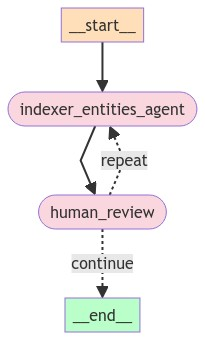

In [14]:
# Load agents
from agents.IndexerEntitiesAgent import IndexerEntitiesAgent,indexer_entities_agent_model

# Entity Logic Agent
indexer_entities_model = indexer_entities_agent_model()
indexer_entities_agent = IndexerEntitiesAgent(indexer_entities_model)
        

from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

## Define the Agent nodes
workflow.add_node("indexer_entities_agent", indexer_entities_agent.call_model)
workflow.add_node("human_review",review_agent.human_review)

## Add Edges
workflow.set_entry_point("indexer_entities_agent")
workflow.add_edge("indexer_entities_agent","human_review")

# Human review of schema
workflow.add_conditional_edges(
    "human_review",
    human_review_router,
    {
        "continue": END,
        "repeat": "indexer_entities_agent",
    }   
)

entity_app = workflow.compile()
display(Image(entity_app.get_graph(xray=True).draw_mermaid_png()))

In [15]:
# from langchain_core.messages import HumanMessage
# from agents.IndexerEntitiesAgent import EntityResponse

# # app.nearcrowd.near example
# # question = f"""
# #     Identify the key entities from the supplied block schema.
# # """

# ## social.near example
# question = """Identify the key entities from the supplied block schema that came from receiver 'social.near'.
#     """ 

# ## pool.near and poolv1.near example
# # question = """Identify the key entities from the supplied block schema that came from the initial prompt:
# #             Build me a staking indexer that tracks validators, deposits and withdrawals to any receiver that ends with *.pool.near or *.poolv1.near. 
# #             I want to be able to query the list of validators with their history of balances. 
# #             I also want to be able to track the staked balance per each account that staked.
# #     """ 

# # Example usage
# result = entity_app.invoke({"messages": [HumanMessage(content=question)],
#                     "original_prompt": question,
#                      "entity_schema": entity_schema,
#                      "block_heights":[],
#                      "block_data_extraction_code":block_data_extraction_code,
#                      "table_creation_code":"",
#                      "indexer_entities_description":"",
#                      "data_upsertion_code": "",
#                      "iterations": 0,
#                      "error":"",
#                      "should_continue": False,
#                      })

# print(result['indexer_entities_description'])

# 2. DDL Agent

In [22]:
from tools.JavaScriptRunner import run_js_on_block_only_schema, run_js_on_block,infer_schema_of_js

## app.nearcrowd.near example
# indexer_entities_description = """List of entities: Block, Receipt, FunctionCall.
#  Entity specific data:Block: {signerId: string, blockHeight: number, blockDatetime: string}, Receipt: {receiptId: string, receiptKind: string, receiverId: string, predecessorId: string, status: string, executionOutcomeId: string, logs: string}, FunctionCall: {methodName: string, task_ordinal: number, task_hash: string}
# """.replace('{','{{').replace('}','}}')

## social.near example
indexer_entities_description = """List of entities: Receipt, Predecessor, Receiver, Signer, FunctionCall, Profile, Graph, Index. Entity specific data: Receipt: { receiptId: string, predecessorId: string, receiverId: string, signerId: string, signerPublicKey: string, operations: string } | FunctionCall: { args: string, deposit: string, gas: integer, methodName: string } | Profile: { name: string, linktree: string, image: string, backgroundImage: string } | Graph: { follow: string } | Index: { tosAccept: string }
""".replace('{','{{').replace('}','}}')

block_data_extraction_code = """
    const SOCIAL_DB = "social.near";
    let nearSocialPosts = block.functionCallsToReceiver(SOCIAL_DB).map(fxnCallView => {
        let decodedArgs;
        try {
            decodedArgs = fxnCallView.argsAsJSON(); // Decode the entire args assuming it's a JSON string
        } catch (error) {
            decodedArgs = fxnCallView.args; // Handle cases where decoding fails
        }
        return {
            ...fxnCallView, // Spread the original fxnCallView object to retain all its properties
            args: decodedArgs // Replace the args property with the decoded version
        };
    });
    return nearSocialPosts;
"""

# pool.near and poolv1.near example
# indexer_entities_description = """List of entities: validators, deposits, withdrawals, accounts, receipts, function_calls. Entity specific data: {"validators": "publicKey, stake", "deposits": "receiptId, predecessorId, receiverId, signerId, signerPublicKey, operations", "withdrawals": "receiptId, predecessorId, receiverId, signerId, signerPublicKey, operations", "accounts": "accountId, stakedBalance", "receipts": "receiptId, predecessorId, receiverId, signerId, signerPublicKey, operations", "function_calls": "receiptId, predecessorId, receiverId, signerId, signerPublicKey, operations"}
# """.replace('{','{{').replace('}','}}')

# block_data_extraction_code = """
# function extractData(block) {
#     const actions = block.actions();
#     const receipts = block.receipts();
#     const header = block.header();

#     const successfulReceipts = receipts.filter(receipt => receipt.status.SuccessValue);
#     const filteredActions = actions.filter(action => action.receiverId === 'app.nearcrowd.near' && action.operations.some(op => op.FunctionCall));

#     const result = [];

#     for (const action of filteredActions) {
#       for (const operation of action.operations) {
#         if (operation.FunctionCall) {
#           const receipt = receipts.find(receipt => receipt.receiptId === action.receiptId);
#           if (receipt) {
#             const args = JSON.parse(atob(operation.FunctionCall.args));
#             result.push({
#               signerId: action.signerId,
#               blockHeight: header.height,
#               receiptId: action.receiptId,
#               receipt: receipt,
#               blockDatetime: new Date(parseInt(header.timestampNanosec) / 1000000),
#               methodName: operation.FunctionCall.methodName,
#               ...args
#             });
#           }
#         }
#       }
#     }

#     return result;
#   }
#   return extractData(block);
# """

# entity_schema = json.dumps(run_js_on_block(119688212, extract_block_data_code))
# print(entity_schema)

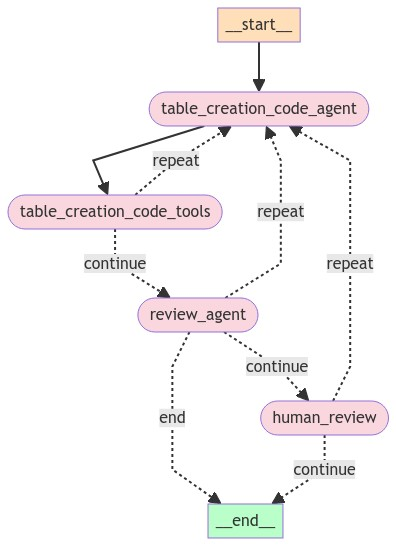

In [17]:
# def table_creation_code_agent_router(state):
#     table_creation_code = state.table_creation_code
#     iterations = state.iterations
#     last_message = state.messages[-1]
#     if hasattr(last_message, 'additional_kwargs'):
#         if "tool_calls" in last_message.additional_kwargs:
#             return "table_creation_code_agent_tool"
#         else:
#             return "review_ddl"
#     elif iterations > 3:
#         return "end"
#     elif table_creation_code == "":
#         return "table_creation_code_agent"
#     else:
#         return "end"

## Create DDL Graph
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

## Define the Agent nodes
workflow.add_node("table_creation_code_agent", table_creation_code_agent.call_model)
workflow.add_node("table_creation_code_tools", table_creation_code_agent.call_tool)
workflow.add_node("review_agent", review_agent.call_model)

## Human Review
workflow.add_node("human_review",review_agent.human_review)

## Add Edges
workflow.set_entry_point("table_creation_code_agent")
workflow.add_edge("table_creation_code_agent", "table_creation_code_tools")

# Add Conditional Edges
workflow.add_conditional_edges(
    "table_creation_code_tools",
    should_review,
    {
        "repeat":"table_creation_code_agent",
        "continue": "review_agent",
    }   
)
# Review code
workflow.add_conditional_edges(
    "review_agent",
    code_review_router,
    {
        "continue":"human_review",
        "repeat": "table_creation_code_agent",
        "end": END
    }   
)
# Check if review passed
workflow.add_conditional_edges(
    "human_review",
    human_review_router,
    {
        "continue":END,
        "repeat": "table_creation_code_agent",
    }   
)

ddl_app = workflow.compile()

display(Image(ddl_app.get_graph(xray=True).draw_mermaid_png()))

In [18]:
# from langchain_core.messages import HumanMessage

# question = f"""
#     Take this block schema and generate DDL code to create normalized Postgresql tables.
# """

# result = ddl_app.invoke({"messages": [HumanMessage(content=question)],
#                      "original_prompt": question,
#                      "entity_schema": entity_schema,
#                      "block_heights":[],
#                      "block_data_extraction_code":block_data_extraction_code,
#                      "table_creation_code":"",
#                      "data_upsertion_code": "",
#                      "indexer_entities_description": indexer_entities_description,
#                      "iterations": 0,
#                      "error":"",
#                      "should_continue": False,
#                      })

# print(result['table_creation_code'])

# 3. DML Agent

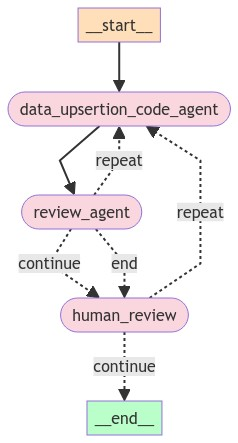

In [23]:
def data_upsertion_code_agent_router(state):
    should_continue = state.should_continue
    iterations = state.iterations
    if should_continue == True:
        return "end"
    elif iterations > 3:
        return "end"
    else:
        return "data_upsertion_code_agent"
    
## Create DDL Graph
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

## Define the Agent nodes
workflow.add_node("data_upsertion_code_agent", data_upsertion_code_agent.call_model)
workflow.add_node("review_agent", review_agent.call_model)

## Human Review
workflow.add_node("human_review",review_agent.human_review)

## Add Edges
workflow.set_entry_point("data_upsertion_code_agent")
workflow.add_edge("data_upsertion_code_agent","review_agent")

# Add Conditional Edges
# Review code
workflow.add_conditional_edges(
    "review_agent",
    code_review_router,
    {
        "continue": "human_review",
        "repeat": "data_upsertion_code_agent",
        "end": "human_review", # for now short circuit ending after 3 tries
    }   
)
workflow.add_conditional_edges(
    "human_review",
    human_review_router,
    {
        "continue": END,
        "repeat": "data_upsertion_code_agent",
    }   
)

DataUpsertion_app = workflow.compile()
display(Image(DataUpsertion_app.get_graph(xray=True).draw_mermaid_png()))

In [24]:
## app.nearcrowd.near example
# psql = {
#     "ddl": "CREATE TABLE IF NOT EXISTS block_data (\n    signer_id VARCHAR(255),\n    block_height BIGINT,\n    receipt_id VARCHAR(255) PRIMARY KEY,\n    receipt_kind VARCHAR(255),\n    receiver_id VARCHAR(255),\n    predecessor_id VARCHAR(255),\n    status_value VARCHAR(255),\n    execution_outcome_id VARCHAR(255),\n    logs JSONB,\n    block_datetime TIMESTAMP,\n    method_name VARCHAR(255),\n    task_ordinal INTEGER,\n    task_hash BYTEA\n);"
# }

## social.near example
psql = {
    "ddl": "CREATE TABLE receipt (    receipt_id VARCHAR PRIMARY KEY,    predecessor_id VARCHAR NOT NULL,    receiver_id VARCHAR NOT NULL,    signer_id VARCHAR NOT NULL,    signer_public_key VARCHAR NOT NULL,    operations TEXT NOT NULL);CREATE TABLE function_call (    id SERIAL PRIMARY KEY,    args JSONB NOT NULL,    deposit VARCHAR NOT NULL,    gas INTEGER NOT NULL,    method_name VARCHAR NOT NULL,    receipt_id VARCHAR REFERENCES receipt(receipt_id));CREATE TABLE profile (    id SERIAL PRIMARY KEY,    name VARCHAR NOT NULL,    linktree JSONB NOT NULL,    image JSONB NOT NULL,    background_image JSONB NOT NULL,    account_id VARCHAR NOT NULL);CREATE TABLE graph (    id SERIAL PRIMARY KEY,    follow JSONB NOT NULL,    account_id VARCHAR NOT NULL);CREATE TABLE index_table (    id SERIAL PRIMARY KEY,    tos_accept VARCHAR NOT NULL,    account_id VARCHAR NOT NULL);"
}

## pool.near and poolv1.near example
# psql = {
#     "ddl": "CREATE TABLE validators (\n    id SERIAL PRIMARY KEY,\n    public_key VARCHAR NOT NULL,\n    stake VARCHAR NOT NULL\n);\nCREATE TABLE deposits (\n    receipt_id VARCHAR PRIMARY KEY,\n    predecessor_id VARCHAR NOT NULL,\n    receiver_id VARCHAR NOT NULL,\n    signer_id VARCHAR NOT NULL,\n    signer_public_key VARCHAR NOT NULL\n);\nCREATE TABLE withdrawals (\n    receipt_id VARCHAR PRIMARY KEY,\n    predecessor_id VARCHAR NOT NULL,\n    receiver_id VARCHAR NOT NULL,\n    signer_id VARCHAR NOT NULL,\n    signer_public_key VARCHAR NOT NULL\n);\nCREATE TABLE accounts (\n    account_id VARCHAR PRIMARY KEY,\n    staked_balance VARCHAR NOT NULL\n);\nCREATE TABLE receipts (\n    receipt_id VARCHAR PRIMARY KEY,\n    predecessor_id VARCHAR NOT NULL,\n    receiver_id VARCHAR NOT NULL,\n    signer_id VARCHAR NOT NULL,\n    signer_public_key VARCHAR NOT NULL\n);\nCREATE TABLE function_calls (\n    receipt_id VARCHAR PRIMARY KEY,\n    predecessor_id VARCHAR NOT NULL,\n    receiver_id VARCHAR NOT NULL,\n    signer_id VARCHAR NOT NULL,\n    signer_public_key VARCHAR NOT NULL\n);\nCREATE TABLE operations (\n    id SERIAL PRIMARY KEY,\n    receipt_id VARCHAR NOT NULL REFERENCES receipts(receipt_id),\n    public_key VARCHAR NOT NULL,\n    stake VARCHAR NOT NULL\n);"
# }

table_creation_code = psql['ddl']
print(table_creation_code)

CREATE TABLE receipt (    receipt_id VARCHAR PRIMARY KEY,    predecessor_id VARCHAR NOT NULL,    receiver_id VARCHAR NOT NULL,    signer_id VARCHAR NOT NULL,    signer_public_key VARCHAR NOT NULL,    operations TEXT NOT NULL);CREATE TABLE function_call (    id SERIAL PRIMARY KEY,    args JSONB NOT NULL,    deposit VARCHAR NOT NULL,    gas INTEGER NOT NULL,    method_name VARCHAR NOT NULL,    receipt_id VARCHAR REFERENCES receipt(receipt_id));CREATE TABLE profile (    id SERIAL PRIMARY KEY,    name VARCHAR NOT NULL,    linktree JSONB NOT NULL,    image JSONB NOT NULL,    background_image JSONB NOT NULL,    account_id VARCHAR NOT NULL);CREATE TABLE graph (    id SERIAL PRIMARY KEY,    follow JSONB NOT NULL,    account_id VARCHAR NOT NULL);CREATE TABLE index_table (    id SERIAL PRIMARY KEY,    tos_accept VARCHAR NOT NULL,    account_id VARCHAR NOT NULL);


In [25]:
from langchain_core.messages import HumanMessage

question = f"""
    Take this Postgresql schema and Javascript function for parsing parse blocks and generate DataUpsertion code to upsert data into Postgresql tables.
"""

result = DataUpsertion_app.invoke({"messages": [HumanMessage(content=question)],
                     "original_prompt": question, 
                     "entity_schema": entity_schema,
                     "block_limit":10,
                     "previous_day_limit":3,
                     "block_heights":[],
                     "block_data_extraction_code":block_data_extraction_code,
                     "table_creation_code":table_creation_code,
                     "data_upsertion_code": "",
                     "indexer_entities_description":"",
                     "iterations": 0,
                     "error":"",
                     "should_continue": False,
                     })

data_upsertion_code = result["data_upsertion_code"].replace('\\n','\n')
# print(result['block_data_extraction_code'])
print(data_upsertion_code)

Generating Data Upsertion Code
Reviewing code...
Code is not valid. Repeating: Data Upsertion.
Generating Data Upsertion Code
Reviewing code...
import * as primitives from "@near-lake/primitives";
async function getBlock(block) {
    const SOCIAL_DB = "social.near";

    function base64decode(encodedValue) {
        let buff = Buffer.from(encodedValue, "base64");
        return JSON.parse(buff.toString("utf-8"));
    }

    async function handleReceipt(receipt) {
        try {
            const receiptData = {
                receipt_id: receipt.action.receiptId,
                predecessor_id: receipt.action.predecessorId,
                receiver_id: receipt.action.receiverId,
                signer_id: receipt.action.signerId,
                signer_public_key: receipt.action.signerPublicKey,
                operations: JSON.stringify(receipt.action.operations)
            };

            await context.db.Receipt.upsert([receiptData], ["receipt_id"], [
                "predecessor_i

# Appendix

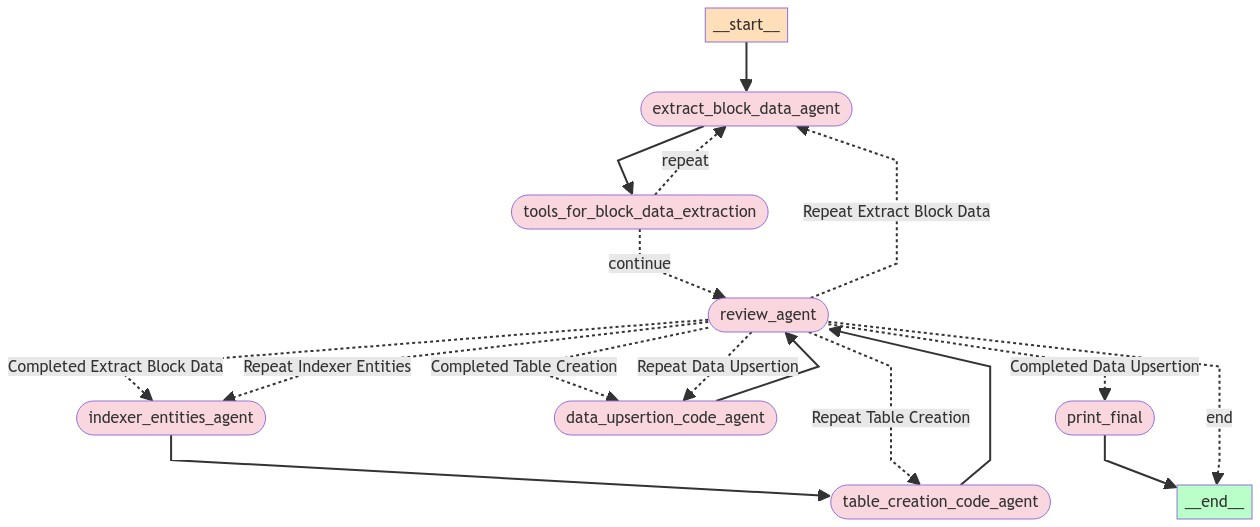

In [ ]:
# test graph no human review
import sys
sys.path.append('..')
from graph.master_graph import create_graph_no_human_review
from langchain_core.messages import HumanMessage
from IPython.display import Image, display

workflow = create_graph_no_human_review()
no_review_app = workflow.compile()
display(Image(no_review_app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# # Testing Output JS
# from tools.JavaScriptRunner import run_js_on_block
# js_test = """
# return (function extractData(block) {
#     const results = [];
#     const actions = block.actions();
#     const receipts = block.receipts();
#     const header = block.header();
#     const height = header.height;
#     const datetime = new Date(parseInt(header.timestampNanosec) / 1e6);

#     actions
#         .filter(action => action.receiverId === 'app.nearcrowd.near')
#         .flatMap(action => {
#             const receipt = receipts.find(r => r.receiptId === action.receiptId);
#             if (receipt && receipt.status && receipt.status.SuccessValue !== undefined) {
#                 return action.operations
#                     .map(operation => operation.FunctionCall)
#                     .filter(operation => operation)
#                     .map(functionCallOperation => {
#                         try {
#                             const args = JSON.parse(Buffer.from(functionCallOperation.args, 'base64').toString('utf-8'));
#                             return {
#                                 signerId: action.signerId,
#                                 blockHeight: height,
#                                 receiptId: action.receiptId,
#                                 blockDatetime: datetime,
#                                 methodName: functionCallOperation.methodName,
#                                 ...args
#                             };
#                         } catch (error) {
#                             console.log('Failed to decode or parse function call args', functionCallOperation, error);
#                             return null;
#                         }
#                     })
#                     .filter(result => result !== null);
#             }
#             return [];
#         })
#         .forEach(result => results.push(result));

#     return results;
# })(block);
# """

# code = js_test.replace('\\n', '\n')
# print(code)

# entity_schema = json.dumps(run_js_on_block(119688212, code))
# print(f"\n Attempted to parse on block: {entity_schema}")